In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PowerTransformer, MaxAbsScaler, RobustScaler
import random
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from sklearn.mixture import BayesianGaussianMixture

: 

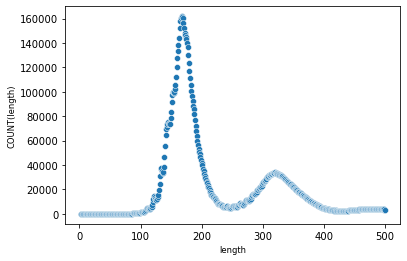

In [56]:
# Hoobari seperated data
# Read in the data
df = pd.read_csv("../data/fetal_lengths.csv", names=['length', 'COUNT(length)'], skiprows=1, dtype=np.int32)
df = df[(df['length'] > 0) & (df['length'] < 501)]
df['norm'] = df['COUNT(length)'] / df['COUNT(length)'].sum()
sns.scatterplot(x='length', y='COUNT(length)', data=df)

X_tag = df['COUNT(length)'].values.reshape(-1, 1)
k_arr = np.arange(7,15,1) + 1
models = [GaussianMixture(n_components=k).fit(X_tag) for k in k_arr]

S36_1 GaussianMixture(n_components=11)
S36_2 GaussianMixture(n_components=9)
S36_3 GaussianMixture(n_components=19)
S37_1 GaussianMixture(n_components=14)
S37_2 GaussianMixture(n_components=16)


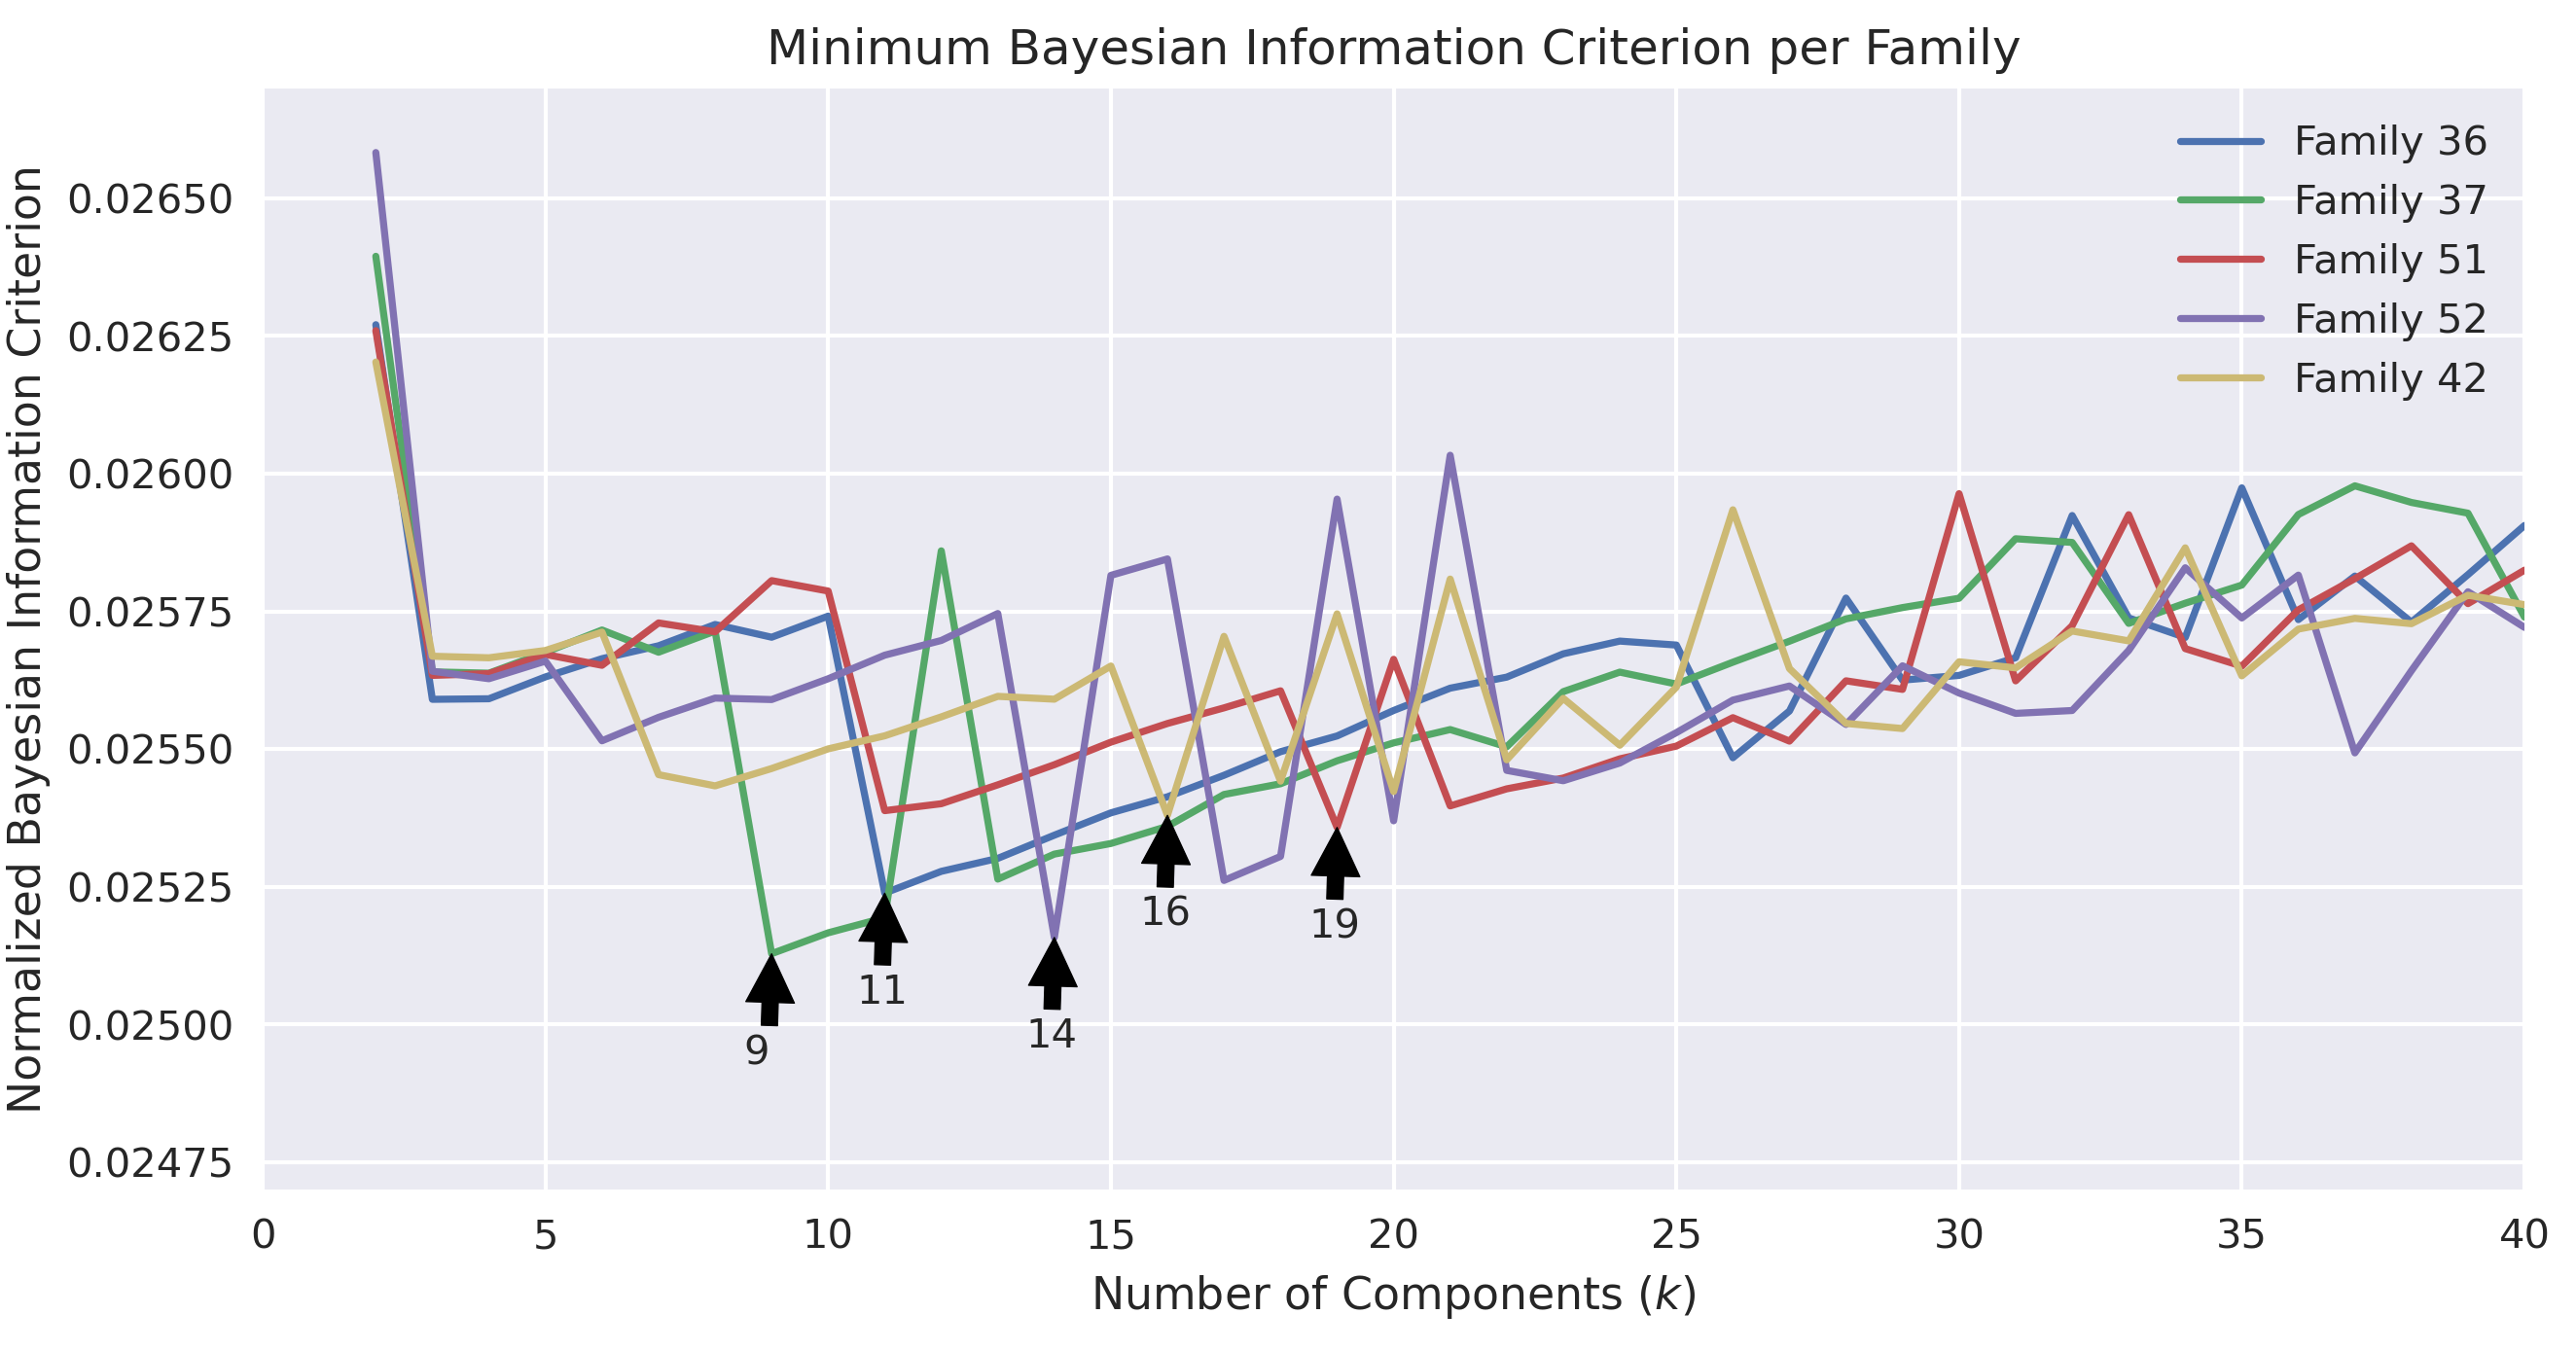

In [30]:
# bamPEFragmentSize output
fams = [36, 37, 51, 52, 42]
df = pd.read_csv("../data/bams/S.FraqLen.tsv", skiprows=1, sep='\t').set_index('Size').groupby('Sample')
samples = {}
i = 0
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    for name, group in df:
        group = group['Occurrences'].to_frame()
        group = group[(group.index > 0) & (group.index < 1001)]

        X_tag = group['Occurrences'].values.reshape(-1, 1)
        k_arr = np.arange(1,40,1) + 1
        models = [GaussianMixture(n_components=k).fit(X_tag) for k in k_arr]

        # Compute metrics to determine best hyperparameter
        AIC = [m.aic(X_tag) for m in models]
        BIC = [m.bic(X_tag) for m in models]
        BIC_norm = [m/sum(BIC) for m in BIC]
        gmm_best = models[np.argmin(BIC)]
        # Plot these metrics
        plt.plot(k_arr, BIC_norm, label="Family {}".format(fams[i]))
        plt.xlabel('Number of Components ($k$)')
        plt.ylabel('Normalized Bayesian Information Criterion')
        plt.legend()
        for index in range(len(k_arr)):
            if gmm_best.n_components == k_arr[index]:
                ax.annotate(gmm_best.n_components, xy=(k_arr[index], BIC_norm[index]), xytext=(k_arr[index] - 0.5, BIC_norm[index] - 0.0002),
                            arrowprops=dict(facecolor='black', shrink=0.001))
                # plt.text(k_arr[index] - 0.5, BIC_norm[index] - 0.0002, gmm_best.n_components, size=10, ha='center', va='bottom')

        samples[name] = [group, X_tag, k_arr, models, AIC, BIC, gmm_best]
        i += 1

    for k,v in samples.items():
        print(k, v[-1])
    
    plt.xlim(0, 40)
    plt.ylim(0.0247, 0.0267)
    plt.title("Minimum Bayesian Information Criterion per Family")
    plt.savefig("../data/bams/BIC.png", bbox_inches='tight')
        

In [117]:
# Plot function
def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
        ax = plt.gca()

    # Compute PDF of whole mixture
    x = np.linspace(-100, 160000, 500)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)

    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    # Plot data histogram
    ax.hist(X, 150, density=True, histtype='stepfilled', alpha=0.4, label='Data')

    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')

    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$p(x)$', fontsize=16)
    
    if show_legend:
        ax.legend()

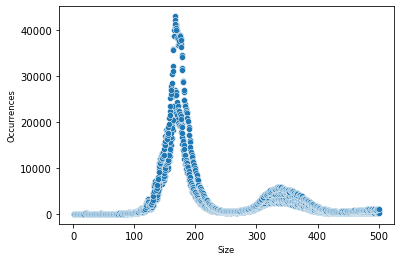

In [123]:
# S36_1 data
# Hoobari seperated data
# Read in the data
df = pd.read_csv("../data/bams/S.FraqLen.tsv",skiprows=1, sep='\t')
df = df[(df['Size'] > 0) & (df['Size'] < 501)]
df['norm'] = df['Occurrences'] / df['Occurrences'].sum()
sns.scatterplot(x='Size', y='Occurrences', data=df)

X_tag = df['Occurrences'].values.reshape(-1, 1)
X_tag
k_arr = np.arange(15,18,1) + 1
models = [GaussianMixture(n_components=k).fit(X_tag) for k in k_arr]

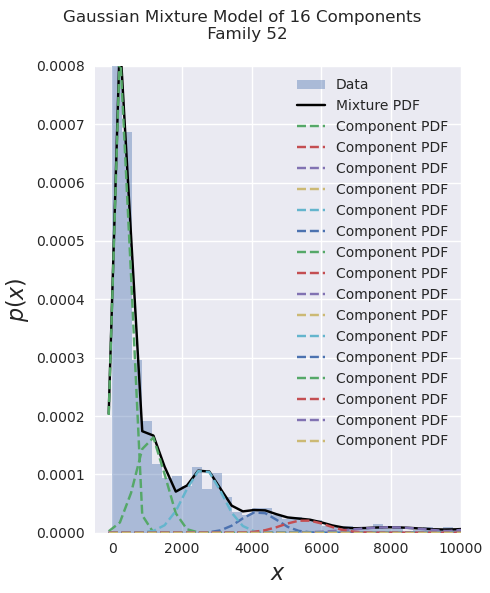

In [130]:
    
with plt.style.context('seaborn'):
    # fig, axes = plt.subplots(1, 3, figsize=np.array([5,2])*3, dpi=500)
    # plt.rcParams.update({'axes.labelsize': 'small'})
    # # plot_mixture(samples['S36_1'][3][0], samples['S36_1'][1], ax=axes)
    # # plt.xlim(0, 000)
    # # plt.ylim(0, 0.001)
    # for gmm, ax in zip(models, axes.ravel()):
    #     plot_mixture(gmm, X_tag, show_legend=True, ax=ax)
    #     ax.set_title(f'k={gmm.n_components}')
    #     ax.set_xlim(-500, 10000)
    #     ax.set_ylim(0, 0.00075)
    #     break
    plt.figure(figsize=(5, 6), dpi=100)
    plot_mixture(models[0], X_tag, show_legend=True)
    # plt.title(f'k={gmm.n_components}')
    plt.xlim(-500, 10000)
    plt.ylim(0, 0.0008)
    plt.suptitle("Gaussian Mixture Model of 16 Components \n Family 52")
    plt.tight_layout()
    plt.savefig("../data/bams/GMM.png", bbox_inches='tight')

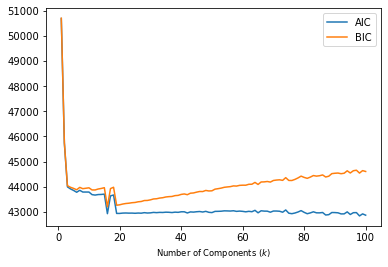

In [89]:
# Compute metrics to determine best hyperparameter
AIC = [m.aic(X_tag) for m in models]
BIC = [m.bic(X_tag) for m in models]
# Plot these metrics
plt.plot(k_arr, AIC, label='AIC')
plt.plot(k_arr, BIC, label='BIC')
plt.xlabel('Number of Components ($k$)')
plt.legend()

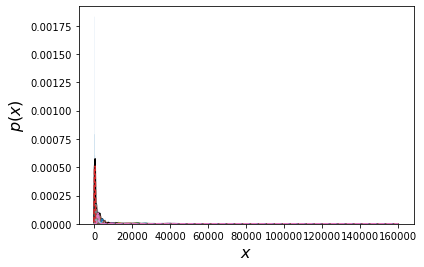

In [90]:
gmm_best = models[np.argmin(BIC)]
plot_mixture(gmm_best, X_tag, show_legend=False)

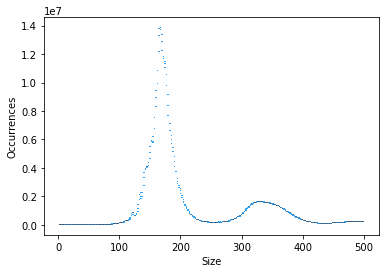

In [135]:
# S36_1 data
# Hoobari seperated data
# Read in the data
df = pd.read_csv("../data/bams/S36_1.FraqLen.tsv",skiprows=1, sep='\t')
df = df[(df['Size'] > 0) & (df['Size'] < 501)]
df['norm'] = df['Occurrences'] / df['Occurrences'].sum()
sns.histplot(x='Size', y='Occurrences', data=df, bins=200)
# sns.scatterplot(x='Size', y='Occurrences', data=df)

X_tag = df['Occurrences'].values.reshape(-1, 1)
# k_arr = np.arange(15,18,1) + 1
# models = [GaussianMixture(n_components=k).fit(X_tag) for k in k_arr]
model = GaussianMixture(n_components=16).fit(X_tag)

In [136]:
sigma = model.covariances_
mu = model.means_

In [122]:
def gen_GMM(N=1000,n_comp=3, mu=[-1,0,1],sigma=[1,1,1],mult=[1,1,1]):
    """
    Generates a Gaussian mixture model data, from a given list of Gaussian components
    N: Number of total samples (data points)
    n_comp: Number of Gaussian components
    mu: List of mean values of the Gaussian components
    sigma: List of sigma (std. dev) values of the Gaussian components
    mult: (Optional) list of multiplier for the Gaussian components
    """
    assert n_comp == len(mu), "The length of the list of mean values does not match number of Gaussian components"
    assert n_comp == len(sigma), "The length of the list of sigma values does not match number of Gaussian components"
    assert n_comp == len(mult), "The length of the list of multiplier values does not match number of Gaussian components"
    rand_samples = []
    for i in range(N):
        pivot = random.uniform(0,n_comp)
        j = int(pivot)
        rand_samples.append(mult[j]*random.gauss(mu[j],sigma[j]))
        
    return np.array(rand_samples)

In [151]:
data = gen_GMM(N=500, n_comp = 16, mu=cov, sigma=sigma, mult=[-6,0,6,-6,0,6,-6,0,6,-6,0,6,-6,0,6,-6])

/data/hadasvol/tools/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


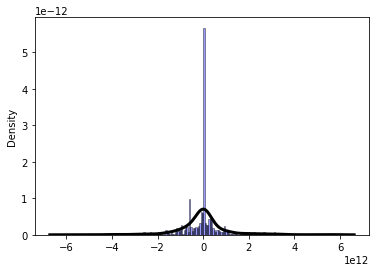

In [152]:
sns.distplot(data,bins=200,hist_kws={'color':'blue','edgecolor':'k'},kde_kws={'lw':3,'color':'k'})
plt.show()

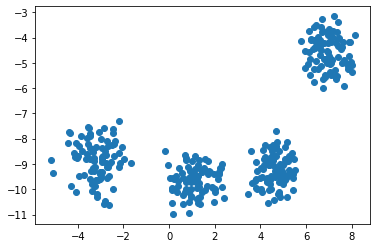

In [156]:
X, y = make_blobs(n_samples=350, centers=4, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], cmap='viridis')

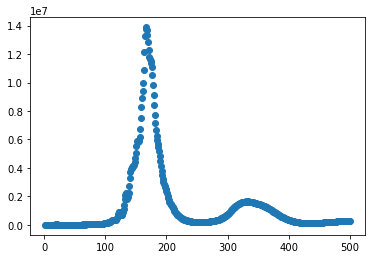

In [169]:
X = df[['Size','Occurrences']].to_numpy()
plt.scatter(X[:, 0], X[:, 1], cmap='viridis')

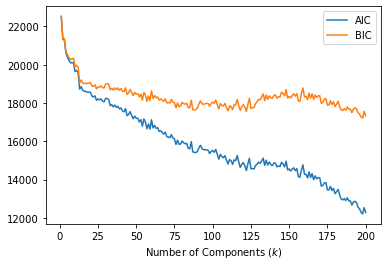

In [186]:
k_arr = np.arange(0,200,1) + 1
models = [GaussianMixture(n_components=k, n_init=10).fit(X) for k in k_arr]
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
# Plot these metrics
plt.plot(k_arr, AIC, label='AIC')
plt.plot(k_arr, BIC, label='BIC')
plt.xlabel('Number of Components ($k$)')
plt.legend()
# gmm = GaussianMixture(n_components=40, n_init=40)
# gmm.fit(X)
# gmm_weights = gmm.weights_
# gmm_weights
# n_clusters_ = (np.round(bay_gmm_weights, 2) > 0).sum()
# print('Estimated number of clusters: ' + str(n_clusters_))
# y_pred  = bay_gmm.predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap="viridis")
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

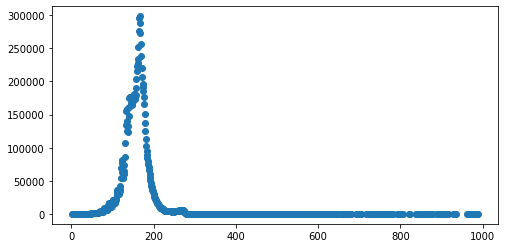

In [2]:
df = pd.read_csv("../data/bams/SLX.tsv",skiprows=1, sep='\t')
df = df[(df['Size'] > 0) & (df['Size'] < 1000)]
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(df['Size'],df['Occurrences'])

(array([ 1.13676151e+05,  1.67392655e+02,  5.22182398e+00,  1.84850017e+05,
        1.55962353e+02, -2.35028722e+01]), array([[ 2.26728497e-01, -4.21372251e-07, -6.29574634e-07,
        -7.34494856e-02, -6.83284528e-06, -3.73211220e-06],
       [-4.21372251e-07,  5.13737423e-10, -2.53866294e-11,
         1.30841196e-06, -9.86924566e-11,  1.85998123e-10],
       [-6.29574634e-07, -2.53866294e-11,  7.51995952e-10,
        -4.96669203e-06, -4.33042879e-10, -2.03681772e-10],
       [-7.34494856e-02,  1.30841196e-06, -4.96669203e-06,
         9.73473130e-02,  5.08274431e-06,  6.06757568e-06],
       [-6.83284528e-06, -9.86924566e-11, -4.33042879e-10,
         5.08274431e-06,  1.28609612e-09,  1.98767029e-10],
       [-3.73211220e-06,  1.85998123e-10, -2.03681772e-10,
         6.06757568e-06,  1.98767029e-10,  9.56080958e-10]]), {'fvec': array([-3.99991120e+00, -4.99988276e+00, -9.99845496e-01, -2.99973312e+00,
       -6.99965019e+00, -3.99954233e+00, -8.99940229e+00, -5.99922082e+00,
      

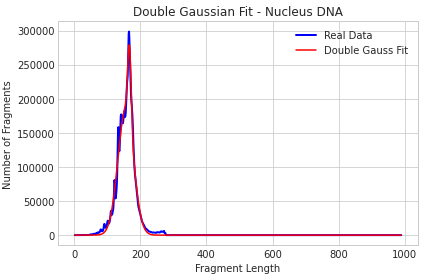

In [20]:
from sklearn import mixture
import matplotlib.pyplot as plt
import matplotlib.mlab
import numpy as np
from pylab import *
from scipy.optimize import leastsq
from scipy.stats import poisson

# data = np.genfromtxt('gaussian_fit.dat', skiprows = 1)
x = df['Size']
y = df['Occurrences']

def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def one_possion(x, params):
    (c1, mu1, sigma1) = params
    res = poisson.pmf(x, df[df['Occurrences'] == y.max()]['Size'])
    return res * y.sum()

def double_gaussian_fit( params ):
    fit = double_gaussian( x, params )
    return (fit - y)

def one_possion_fit( params ):
    fit = one_possion( x, params )
    return (fit - y)

# Least squares fit. Starting values found by inspection.
fit = leastsq( double_gaussian_fit, [1.4e7, 150, 10.0, 0.2e7, 350, 2.0], full_output=1 )
# fit = leastsq( one_possion_fit, [1.4e7, 150, 10.0] )
print(fit)
with plt.style.context('seaborn-whitegrid'):
    plt.plot( x, y, c='b', label='Real Data', linewidth=2)
    plt.plot( x, double_gaussian( x, fit[0] ), c='r', label='Double Gauss Fit' )
    # plt.plot( x, one_possion( x, fit[0] ), c='r', label='Double Gauss Fit' )
    plt.legend()
    plt.xlabel('Fragment Length')
    plt.ylabel('Number of Fragments')
    plt.title('Double Gaussian Fit - Nucleus DNA')
    plt.tight_layout()
    plt.savefig('Nucleus-double_gaussian_fit.png')
print( fit[0] )

In [26]:
import math
import numpy as np
from timebudget import timebudget
import ray

iterations_count = round(1e7)

@ray.remote
def complex_operation(input_index):
    print("Complex operation. Input index: {:2d}".format(input_index))

    [math.exp(i) * math.sinh(i) for i in [1] * iterations_count]

@ray.remote
def complex_operation_numpy(input_index):
    print("Complex operation (numpy). Input index: {:2d}".format(input_index))

    data = np.ones(iterations_count)
    np.exp(data) * np.sinh(data)

@timebudget
def run_complex_operations(operation, input):
    
	ray.get([operation.remote(i) for i in input])

# ray.init()

input = range(10)
print('Without NumPy')
run_complex_operations(complex_operation, input)
print('NumPy')
run_complex_operations(complex_operation_numpy, input)
ray.shutdown()

Without NumPy
(complex_operation pid=208945) Complex operation. Input index:  8
(complex_operation pid=208935) Complex operation. Input index:  9
(complex_operation pid=208948) Complex operation. Input index:  2
(complex_operation pid=208930) Complex operation. Input index:  3
(complex_operation pid=208934) Complex operation. Input index:  4
(complex_operation pid=208941) Complex operation. Input index:  6
(complex_operation pid=208926) Complex operation. Input index:  5
(complex_operation pid=208949) Complex operation. Input index:  0
(complex_operation pid=208933) Complex operation. Input index:  1
(complex_operation pid=208946) Complex operation. Input index:  7
run_complex_operations took 3.538sec
NumPy
(complex_operation_numpy pid=208945) Complex operation (numpy). Input index:  5
(complex_operation_numpy pid=208935) Complex operation (numpy). Input index:  7
(complex_operation_numpy pid=208948) Complex operation (numpy). Input index:  8
(complex_operation_numpy pid=208930) Comple